In [1]:
import numpy as np

In [328]:
import tensorflow as tf

# Load the saved model.
model_dir = '/Users/anrunw/Downloads/l1-jet-id/scripts/trained_mlps/mlp_8bit_8const/kfolding1/'
loaded_model = tf.saved_model.load(model_dir)
loaded_model.trainable = False

# Use the default serving signature.
infer = loaded_model.signatures["serving_default"]

# Determine the input key from the signature.
input_key = list(infer.structured_input_signature[1].keys())[0]
print("Using input key:", input_key)

# Wrap the serving signature in a Keras model.
class LoadedModelWrapper(tf.keras.Model):
    def __init__(self, infer, input_key):
        super(LoadedModelWrapper, self).__init__()
        self.infer = infer
        self.input_key = input_key

    def call(self, inputs, training=False):
        # Call the serving signature using the correct input key.
        outputs = self.infer(**{self.input_key: inputs})
        # If the signature returns a dict, extract the first output.
        # (Adjust this if you know your output key.)
        return list(outputs.values())[0]

# Create an instance of the wrapper.
model = LoadedModelWrapper(infer, input_key)

# Now you can run inference like a normal TF model.


Using input key: input_1


In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class AggregationLayer(layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Given aggregation string is not implemented. Use 'mean' or 'max'.")

# ---------------------------
# Gumbel Softmax Layer with Hard Sampling
# ---------------------------
# Custom Layers
# ---------------------------
class CustomMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

    def build(self, input_shape):
        # input_shape: (batch_size, seq_len, d_model)
        self.wq = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wq")
        self.wk = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wk")
        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # x shape: (batch_size, seq_len, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        # x shape: (batch_size, seq_len, d_model)
        batch_size = tf.shape(x)[0]

        # Linear projections for queries, keys, and values.
        q = tf.matmul(x, self.wq)  # (batch_size, seq_len, d_model)
        k = tf.matmul(x, self.wk)
        v = tf.matmul(x, self.wv)

        # Split into heads.
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled dot-product attention.
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len, seq_len)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        scaled_attention = tf.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, depth)

        # Concatenate heads.
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len, d_model)

        # Final linear layer.
        output = self.dense(concat_attention)  # (batch_size, seq_len, d_model)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.mha = CustomMultiHeadAttention(d_model, num_heads)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.outD = layers.Dense(output_dim)

    def call(self, x):
        # Multi-head attention sub-layer.
        attn_output = self.mha(x)
        out1 = self.layernorm1(x + attn_output)
        # Feed-forward sub-layer.
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        out2 = self.outD(out2)
        return out2

# ---------------------------
# Model Definition
# ---------------------------
def build_custom_transformer_classifier(num_particles, feature_dim,
                                          d_model=16, d_ff=16, output_dim=16,
                                          num_heads=1, attn_temperature=1.0):
    """
    Builds a classifier model with:
      - A linear embedding layer.
      - Multiple transformer encoder blocks using Gumbel Softmax in attention.
      - Aggregation over the sequence dimension using AggregationLayer.
      - A final linear output layer for 5 classes.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    # Linear embedding.
    x = layers.Dense(16, activation='relu')(inputs)

    # Apply multiple transformer blocks.
    x = TransformerBlock(16, 16, output_dim=16, num_heads=8)(x)
    x = TransformerBlock(16, 16, output_dim=16, num_heads=8)(x)
    
    # Custom aggregation (using "max" aggregation here).
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    # Final dense layers.
    x = layers.Dense(16, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

# ---------------------------
# Example Training Loop
# ---------------------------
import numpy as np

# Load your data. Adjust file paths if needed.
from sklearn.model_selection import train_test_split

# Load the original training data
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_32const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_32const_ptetaphi.npy")

# Perform an 80/20 split on the original training data
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

# Determine input dimensions from data.
num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]



# Print model summary.

# Train the model.


# Optionally, print training history.
#print(history.history)


In [ ]:
m

In [12]:
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_32const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_32const_ptetaphi.npy")

# Perform an 80/20 split on the original training data
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)


In [13]:
model = build_custom_transformer_classifier(num_particles, feature_dim,
                                            d_model=8, d_ff=8,
                                            output_dim=8, num_heads=4,
                                            )
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 32, 16)         │         1,920 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 32, 16)         │         1,920 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_2             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,261 (16.64 KB)

 Trainable params: 4,261 (16.64 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=500,
                    batch_size=1024
                    )

Epoch 1/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.5455 - loss: 1.1600 - val_accuracy: 0.6474 - val_loss: 0.9530
Epoch 2/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.6586 - loss: 0.9288 - val_accuracy: 0.6819 - val_loss: 0.8787
Epoch 3/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.6897 - loss: 0.8638 - val_accuracy: 0.6996 - val_loss: 0.8319
Epoch 4/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.7135 - loss: 0.8089 - val_accuracy: 0.7252 - val_loss: 0.7822
Epoch 5/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.7283 - loss: 0.7738 - val_accuracy: 0.7336 - val_loss: 0.7568
Epoch 6/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.7367 - loss: 0.7496 - val_accuracy: 0.7338 - val_loss: 0.7550
Epoch 7/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.7408 - loss: 0.7364 - val_accuracy: 0.7443 - val_loss: 0.7267
Epoch 8/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.7450 - loss: 0

KeyboardInterrupt: 

In [9]:
model.save_weights('transformer2Layer32.weights.h5')

In [15]:
model.load_weights('transformer2Layer32.weights.h5')

/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [58]:
model.save_weights("model_softmax16noLN.weights.h5")

In [ ]:
model.load('model_softmax.weights.h5')

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---------------------------
# Aggregation Layer
# ---------------------------
class AggregationLayer(layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Given aggregation string is not implemented. Use 'mean' or 'max'.")

# ---------------------------
# Linformer Multi-Head Attention
# ---------------------------
class LinformerMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, proj_dim, **kwargs):
        """
        Args:
          d_model: Dimensionality of the model.
          num_heads: Number of attention heads.
          proj_dim: The projection dimension to which keys and values will be reduced.
        """
        super(LinformerMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.proj_dim = proj_dim

    def build(self, input_shape):
        # input_shape: (batch_size, seq_len, d_model)
        self.seq_len = input_shape[1]
        # Standard dense weight matrices for Q, K, and V.
        self.wq = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wq")
        self.wk = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wk")
        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)
        # Learnable projection matrices for keys and values.
        # These project along the sequence dimension from seq_len -> proj_dim.
        self.E = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_E")
        self.F = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_F")
        super(LinformerMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # x shape: (batch_size, seq_len, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # Transpose to shape: (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Compute linear projections.
        q = tf.matmul(x, self.wq)  # (batch_size, seq_len, d_model)
        k = tf.matmul(x, self.wk)
        v = tf.matmul(x, self.wv)

        # Split into multiple heads.
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Project keys and values along the sequence dimension.
        # Using Einstein summation: for each head h,
        #   k_proj[b, h] = E[h]^T (applied on the sequence dim of k[b, h])
        # k_proj shape: (batch_size, num_heads, proj_dim, depth)
        k_proj = tf.einsum('bhnd, hnr -> bhrd', k, self.E)
        v_proj = tf.einsum('bhnd, hnr -> bhrd', v, self.F)

        # Scaled dot-product attention.
        # Compute scores between queries and projected keys.
        # scores shape: (batch_size, num_heads, seq_len, proj_dim)
        dk = tf.cast(self.depth, tf.float32)
        scores = tf.matmul(q, k_proj, transpose_b=True) / tf.math.sqrt(dk)
        attn_weights = tf.nn.softmax(scores, axis=-1)

        # Compute the attention output.
        # Output shape: (batch_size, num_heads, seq_len, depth)
        attn_output = tf.matmul(attn_weights, v_proj)

        # Concatenate heads.
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        concat_output = tf.reshape(attn_output, (batch_size, -1, self.d_model))
        output = self.dense(concat_output)
        return output

# ---------------------------
# Linformer Transformer Block
# ---------------------------
class LinformerTransformerBlock(layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, proj_dim, **kwargs):
        super(LinformerTransformerBlock, self).__init__(**kwargs)
        self.attention = LinformerMultiHeadAttention(d_model, num_heads, proj_dim)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.outD = layers.Dense(output_dim)

    def call(self, x):
        attn_output = self.attention(x)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# ---------------------------
# Linformer Transformer Classifier Model
# ---------------------------
def build_linformer_transformer_classifier(num_particles, feature_dim,
                                             d_model=16, d_ff=16, output_dim=16,
                                             num_heads=1, proj_dim=8):
    """
    Builds a classifier model with:
      - A linear embedding layer.
      - Multiple Linformer transformer blocks.
      - Aggregation over the sequence dimension.
      - A final linear output layer for 5 classes.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    # Linear embedding.
    x = layers.Dense(d_model, activation='relu')(inputs)
    
    # Apply multiple Linformer transformer blocks.
    x = LinformerTransformerBlock(d_model, d_ff, output_dim, num_heads, proj_dim)(x)
    x = LinformerTransformerBlock(d_model, d_ff, output_dim, num_heads, proj_dim)(x)
    
    # Aggregation (using "max" aggregation).
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    # Final dense layers.
    x = layers.Dense(d_model, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

# ---------------------------
# Example Training Setup
# ---------------------------
import numpy as np
from sklearn.model_selection import train_test_split

# Load your data.
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_16const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_16const_ptetaphi.npy")

# 80/20 split for training and validation.
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

# Determine input dimensions from data.
num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]

# Build and compile the Linformer transformer classifier.
model = build_linformer_transformer_classifier(num_particles, feature_dim,
                                               d_model=16, d_ff=16, output_dim=16,
                                               num_heads=8, proj_dim=4)
model.load_weights('linformer.weights.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()




/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'linformer_transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'linformer_transformer_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block     │ (None, 16, 16)         │         2,672 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_1   │ (None, 16, 16)         │         2,672 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_1             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,765 (22.52 KB)

 Trainable params: 5,765 (22.52 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_26  │ (None, 16, 16)         │         2,672 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_27  │ (None, 16, 16)         │         2,672 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_13            │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,765 (22.52 KB)

 Trainable params: 5,765 (22.52 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=100,
                    batch_size=1024
                    )

Epoch 1/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.7224 - loss: 0.7656 - val_accuracy: 0.7174 - val_loss: 0.7785
Epoch 2/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.7232 - loss: 0.7643 - val_accuracy: 0.7110 - val_loss: 0.7907
Epoch 3/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.7207 - loss: 0.7683 - val_accuracy: 0.7165 - val_loss: 0.7784
Epoch 4/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.7219 - loss: 0.7667 - val_accuracy: 0.7169 - val_loss: 0.7785
Epoch 5/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.7241 - loss: 0.7612 - val_accuracy: 0.7168 - val_loss: 0.7784
Epoch 6/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.7223 - loss: 0.7643 - val_accuracy: 0.7167 - val_loss: 0.7793
Epoch 7/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.7215 - loss: 0.7659 - val_accuracy: 0.7101 - val_loss: 0.7943
Epoch 8/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.7221 - loss: 0

KeyboardInterrupt: 

In [117]:
model.save_weights('linformer.weights.h5')

In [19]:
import matplotlib.pyplot as plt

In [16]:
import matplotlib.pyplot as plt

# Suppose you have already trained your model:
# history = model.fit(...)

# Plotting the training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# If you also have accuracy or other metrics, you can plot them similarly:
if 'accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
model.save_weights('linformer.weights.h5')

In [105]:
import matplotlib.pyplot as plt

In [153]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Check for available GPUs.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs found. Ensure tensorflow-macos and tensorflow-metal are installed for GPU acceleration on M2 Macs.")


# ---------------------------
# Gumbel Softmax Layer with Hard Sampling
# ---------------------------
class GumbelSoftmax(layers.Layer):

    def __init__(self, temperature=1.0, hard=False, **kwargs):
        super(GumbelSoftmax, self).__init__(**kwargs)
        self.temperature = temperature
        self.hard = hard

    def sample_gumbel(self, shape, eps=1e-20):
        U = tf.random.uniform(shape, minval=0, maxval=1)
        return -tf.math.log(-tf.math.log(U + eps) + eps)

    def call(self, logits):
        noise = self.sample_gumbel(tf.shape(logits))
        y = logits + noise
        y_soft = tf.nn.softmax(y / self.temperature, axis=-1)
        if self.hard:
            y_hard = tf.one_hot(tf.argmax(y_soft, axis=-1), depth=tf.shape(y_soft)[-1])
            y = tf.stop_gradient(y_hard - y_soft) + y_soft
            return y
        else:
            return y_soft


# ---------------------------
# Aggregation Layer
# ---------------------------
class AggregationLayer(layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Given aggregation string is not implemented. Use 'mean' or 'max'.")


# ---------------------------
# Custom Multi-Head Attention with Gumbel Softmax
# ---------------------------
class CustomMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, attn_temperature=1.0, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.attn_temperature = attn_temperature
        self.attn_matrix = []

    def build(self, input_shape):
        # Define weight matrices for Q, K, V.
        self.wq = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wq")
        self.wk = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wk")
        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # Reshape x to (batch_size, seq_len, num_heads, depth) then transpose.
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]

        # Compute Q, K, V.
        q = tf.matmul(x, self.wq)  # (batch_size, seq_len, d_model)
        k = tf.matmul(x, self.wk)
        v = tf.matmul(x, self.wv)

        # Split into multiple heads.
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Compute scaled dot-product attention logits.
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len, seq_len)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Apply Gumbel Softmax (with hard sampling) instead of standard softmax.
        gumbel_layer = GumbelSoftmax(temperature=self.attn_temperature, hard=True)
        attention_weights = gumbel_layer(scaled_attention_logits)
        # Compute attention output.
        scaled_attention = tf.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, depth)

        # Concatenate heads.
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len, d_model)

        # Final linear layer.
        output = self.dense(concat_attention) 
        self.attn_matrix.append(attention_weights)
        return output, attention_weights


# ---------------------------
# Transformer Block
# ---------------------------
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, attn_temperature=1.0, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.mha = CustomMultiHeadAttention(d_model, num_heads, attn_temperature=attn_temperature)

        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.outD = layers.Dense(16)
        self.outD2 = layers.Dense(16)

    def call(self, x):
        # Multi-head attention sub-layer.
        attn_output = self.mha(x)[0]
        out1 = self.outD(x + attn_output)
        # Feed-forward sub-layer.
        ffn_output = self.ffn(out1)
        out2 = out1 + ffn_output
        out2 = self.outD2(out2)

        return out2


# ---------------------------
# Model Definition
# ---------------------------
def build_custom_transformer_classifier(num_particles, feature_dim,
                                          d_model=16, d_ff=16, output_dim=16,
                                          num_heads=1, attn_temperature=0.5):
    """
    Builds a classifier model with:
      - A linear embedding layer.
      - Multiple transformer encoder blocks using Gumbel Softmax in attention.
      - Aggregation over the sequence dimension using AggregationLayer.
      - A final linear output layer for 5 classes.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    # Linear embedding.
    x = layers.Dense(16, activation='relu')(inputs)

    # Apply multiple transformer blocks.
    x = TransformerBlock(16, 16, output_dim=8, num_heads=8, attn_temperature=attn_temperature)(x)

    
    # Custom aggregation (using "max" aggregation here).
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    # Final dense layers.
    x = layers.Dense(16, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)


# ---------------------------
# Training Loop
# ---------------------------
import numpy as np

# Load your data.
# Determine input dimensions.
num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]

# Build and compile the model.
model = build_custom_transformer_classifier(num_particles, feature_dim,
                                            d_model=8, d_ff=8,
                                            output_dim=8, num_heads=4,
                                            attn_temperature= 0.1)
model.load_weights('model_gumbel_softmax16noLN.weights.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Print model summary.
model.summary()

# Train the model.



Using GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Model: "functional_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_120 (InputLayer)    │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_495 (Dense)               │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_78            │ (None, 16, 16)         │         2,128 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_39            │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_502 (Dense)               │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,549 (9.96 KB)

 Trainable params: 2,549 (9.96 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
model.

SyntaxError: invalid syntax (1068564517.py, line 1)

In [154]:
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=1000,
                    batch_size=4096
                    )

# Optionally, print training history.
print(history.history)

Epoch 1/1000
 61/122 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.6937 - loss: 0.8362 

KeyboardInterrupt: 

In [92]:
model.save_weights("model_gumbel_softmax16noLN.weights.h5")

In [233]:
model = loaded_model

In [17]:
x_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_32const_ptetaphi.npy")
y_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_32const_ptetaphi.npy")

In [119]:
len(x_val)

260000

In [18]:
xout = np.argmax(model(x_val, training=False),1)

In [19]:
yout = np.argmax(y_val,1)

In [21]:
import sklearn

In [22]:
sklearn.metrics.accuracy_score(xout,yout)

0.7893807692307693

In [125]:
model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_26  │ (None, 16, 16)         │         2,672 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_27  │ (None, 16, 16)         │         2,672 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_13            │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,297 (67.57 KB)

 Trainable params: 5,765 (22.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,532 (45.05 KB)

In [124]:
model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_26  │ (None, 16, 16)         │         2,672 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_27  │ (None, 16, 16)         │         2,672 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_13            │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,297 (67.57 KB)

 Trainable params: 5,765 (22.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,532 (45.05 KB)

In [23]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import time
import numpy as np

def get_flops(model, input_shape):
    # Create a concrete function from the Keras model.
    input_tensor = tf.TensorSpec(input_shape, tf.float32)
    concrete_func = tf.function(model).get_concrete_function(input_tensor)
    
    # Convert the model to a frozen graph.
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    # Import the graph_def into a new graph.
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

# Assuming x_val is already loaded and has shape (num_samples, features, ...)
# For a single event, we use a batch size of 1.
input_shape = [1] + list(x_val.shape[1:])
total_flops = get_flops(model, input_shape)
print("Total FLOPs for a single inference:", total_flops)

# ---------------------------
# Time Inference Per Event
# ---------------------------
# Warm-up: Run one inference to load any lazy initializations.
import numpy as np
import time

# Warm-up (optional but recommended)
_ = model(x_val[:10000])

num_trials = 100
inference_times = []
for _ in range(num_trials):
    start_time = time.perf_counter()
    _ = model(x_val[:10000])
    end_time = time.perf_counter()
    inference_times.append(end_time - start_time)

# Compute average inference time per event in seconds, then convert to nanoseconds
avg_inference_time_seconds = np.mean(np.array(inference_times) / 10000)
avg_inference_time_nanoseconds = avg_inference_time_seconds * 1e9

print("Average inference time per event:", np.round(avg_inference_time_nanoseconds,3), "nanoseconds")



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


2025-03-27 00:39:31.465244: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-03-27 00:39:31.465348: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-03-27 00:39:31.465659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-27 00:39:31.465676: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Total FLOPs for a single inference:
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Pl

1/FPR at TPR=80% for each class:
g: 1/FPR = 9.729846269216347
q: 1/FPR = 8.632307502162897
W: 1/FPR = 37.00178094390027
Z: 1/FPR = 51.57735286814005
t: 1/FPR = 27.394663848897107
Average 1/FPR across classes: 26.867190286463334

Accuracy at the threshold corresponding to TPR=80% for each class:
g: accuracy = 0.8776
q: accuracy = 0.8678
W: accuracy = 0.9382
Z: accuracy = 0.9443
t: accuracy = 0.9304
Average accuracy across classes: 0.9117


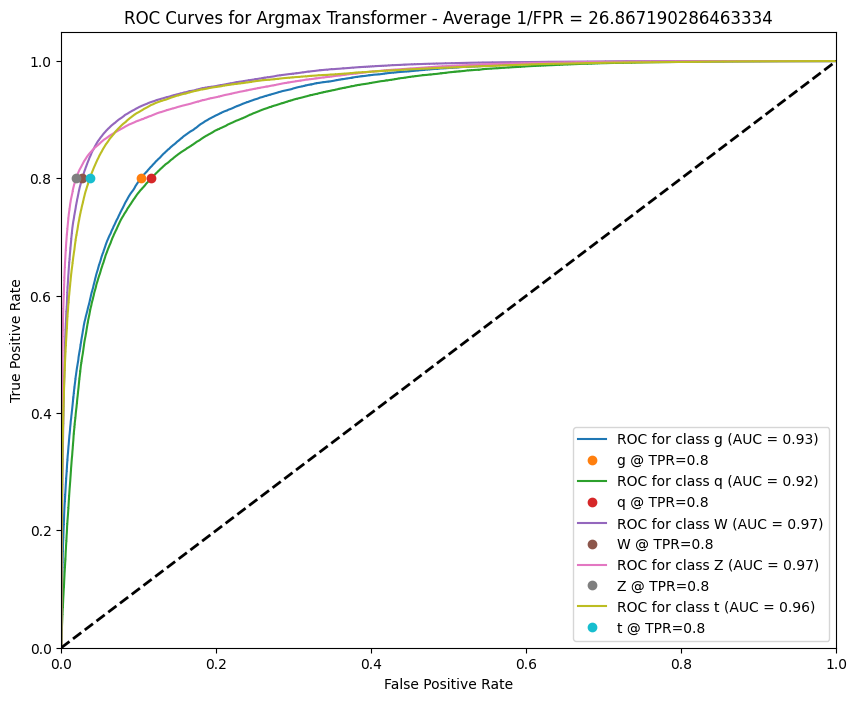

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# Define your class labels.
class_labels = ['g', 'q', 'W', 'Z', 't']

# Load your validation data.
# (Assuming x_val and y_val are already loaded in your environment)
# Get the model predictions as probabilities.
# If your model outputs logits, you may need to apply softmax first.
y_pred = model(x_val, training=False)

# Convert predictions and labels from TensorFlow tensors to NumPy arrays if needed.
if hasattr(y_pred, "numpy"):
    y_pred = y_pred.numpy()
if hasattr(y_val, "numpy"):
    y_val = y_val.numpy()

# Initialize dictionaries to store false positive rates, true positive rates, AUC, thresholds,
# interpolated FPR at target TPR, and accuracy at that threshold.
fpr = {}
tpr = {}
roc_auc = {}
thresholds_dict = {}
fpr_at_target = {}
accuracy_at_target = {}

# Target true positive rate.
target_tpr = 0.8

# Compute ROC curve, AUC, and interpolate FPR and threshold at target TPR for each class.
for i, label in enumerate(class_labels):
    # Compute ROC curve: returns fpr, tpr, and thresholds.
    fpr[i], tpr[i], thresholds = roc_curve(y_val[:, i], y_pred[:, i])
    thresholds_dict[i] = thresholds  # save thresholds for later use
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Check if the target TPR is reached.
    if target_tpr <= tpr[i][-1]:
        # Interpolate FPR at target TPR.
        fpr_at_target[label] = np.interp(target_tpr, tpr[i], fpr[i])
        # Interpolate threshold at target TPR.
        threshold_at_target = np.interp(target_tpr, tpr[i], thresholds)
        # Compute binary predictions for the current class using the interpolated threshold.
        preds_binary = (y_pred[:, i] >= threshold_at_target).astype(int)
        # Compute accuracy for the current class.
        accuracy = np.mean(preds_binary == y_val[:, i])
        accuracy_at_target[label] = accuracy
    else:
        fpr_at_target[label] = None  # If target TPR is not reached.
        accuracy_at_target[label] = None

# Display the 1/FPR values when TPR=80% for each class.
print("1/FPR at TPR=80% for each class:")
one_over_fpr = []
for label in class_labels:
    if fpr_at_target[label] is not None and fpr_at_target[label] != 0:
        inv_val = 1.0 / fpr_at_target[label]
        one_over_fpr.append(inv_val)
        print(f"{label}: 1/FPR = {inv_val}")
    else:
        print(f"{label}: undefined (FPR is None or zero)")

# Compute and print the average of 1/FPR across classes.
if one_over_fpr:
    avg_one_over_fpr = np.mean(one_over_fpr)
    print(f"Average 1/FPR across classes: {avg_one_over_fpr}")
else:
    print("No valid 1/FPR values to compute an average.")

# Print the accuracy at the FPR corresponding to TPR=80% for each class.
print("\nAccuracy at the threshold corresponding to TPR=80% for each class:")
accuracies = []
for label in class_labels:
    if accuracy_at_target[label] is not None:
        accuracies.append(accuracy_at_target[label])
        print(f"{label}: accuracy = {accuracy_at_target[label]:.4f}")
    else:
        print(f"{label}: accuracy undefined (target TPR not reached)")
if accuracies:
    avg_accuracy = np.mean(accuracies)
    print(f"Average accuracy across classes: {avg_accuracy:.4f}")
else:
    print("No valid accuracy values to compute an average.")

# Plot the ROC curves and mark the point corresponding to TPR=0.8.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f'ROC for class {label} (AUC = {roc_auc[i]:.2f})')
    if fpr_at_target[label] is not None:
        # Mark the point on the ROC curve where TPR = 0.8.
        plt.plot(fpr_at_target[label], target_tpr, 'o', label=f'{label} @ TPR=0.8')

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Argmax Transformer - Average 1/FPR = ' + str(avg_one_over_fpr))
plt.legend(loc="lower right")
plt.show()



In [177]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---------------------------
# Gumbel Softmax Layer with Hard Sampling
# ---------------------------
class GumbelSoftmax(layers.Layer):
    """
    Applies the Gumbel Softmax trick to sample from a categorical distribution
    in a differentiable way. If hard=True, uses the straight-through estimator
    to return one-hot vectors in the forward pass.
    """
    def __init__(self, temperature=1.0, hard=False, **kwargs):
        super(GumbelSoftmax, self).__init__(**kwargs)
        self.temperature = temperature
        self.hard = hard

    def sample_gumbel(self, shape, eps=1e-20):
        U = tf.random.uniform(shape, minval=0, maxval=1)
        return -tf.math.log(-tf.math.log(U + eps) + eps)

    def call(self, logits):
        noise = self.sample_gumbel(tf.shape(logits))
        y = logits + noise
        y_soft = tf.nn.softmax(y / self.temperature, axis=-1)
        if self.hard:
            # Straight-through estimator: one-hot encode the sample.
            y_hard = tf.one_hot(tf.argmax(y_soft, axis=-1), depth=tf.shape(y_soft)[-1])
            y = tf.stop_gradient(y_hard - y_soft) + y_soft
            return y
        else:
            return y_soft


# ---------------------------
# Aggregation Layer
# ---------------------------
class AggregationLayer(layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Given aggregation string is not implemented. Use 'mean' or 'max'.")


# ---------------------------
# Custom Multi-Head Attention with Gumbel Softmax
# ---------------------------
class CustomMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, attn_temperature=1.0, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.attn_temperature = attn_temperature

    def build(self, input_shape):
        # Define weight matrices for Q, K, V.
        self.wq = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wq")
        self.wk = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wk")
        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # Reshape x to (batch_size, seq_len, num_heads, depth) then transpose.
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]

        # Compute Q, K, V.
        q = tf.matmul(x, self.wq)  # (batch_size, seq_len, d_model)
        k = tf.matmul(x, self.wk)
        v = tf.matmul(x, self.wv)

        # Split into multiple heads.
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Compute scaled dot-product attention logits.
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len, seq_len)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Replace Gumbel softmax with argmax and one-hot encoding.
        indices = tf.argmax(scaled_attention_logits, axis=-1)
        attention_weights = tf.one_hot(indices, depth=tf.shape(scaled_attention_logits)[-1], dtype=scaled_attention_logits.dtype)


        # Compute attention output.
        scaled_attention = tf.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, depth)

        # Concatenate heads.
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len, d_model)

        # Final linear layer.
        output = self.dense(concat_attention)
        return output


# ---------------------------
# Transformer Block
# ---------------------------
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, attn_temperature=1.0, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.mha = CustomMultiHeadAttention(d_model, num_heads, attn_temperature=attn_temperature)

        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.outD = layers.Dense(16)
        self.outD2 = layers.Dense(16)

    def call(self, x):
        # Multi-head attention sub-layer.
        attn_output = self.mha(x)
        out1 = self.outD(x + attn_output)
        # Feed-forward sub-layer.
        ffn_output = self.ffn(out1)
        out2 = out1 + ffn_output
        out2 = self.outD2(out2)
        return out2


# ---------------------------
# Model Definition
# ---------------------------
def build_custom_transformer_classifier(num_particles, feature_dim,
                                          d_model=16, d_ff=16, output_dim=16,
                                          num_heads=1, attn_temperature=1.0):
    """
    Builds a classifier model with:
      - A linear embedding layer.
      - Multiple transformer encoder blocks using Gumbel Softmax in attention.
      - Aggregation over the sequence dimension using AggregationLayer.
      - A final linear output layer for 5 classes.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    # Linear embedding.
    x = layers.Dense(16, activation='relu')(inputs)
    
    # Apply multiple transformer blocks.
    x = TransformerBlock(16, 16, output_dim=8, num_heads=8, attn_temperature=attn_temperature)(x)
    
    # Custom aggregation (using "max" aggregation here).
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    # Final dense layers.
    x = layers.Dense(16, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)


# ---------------------------
# Training Loop
# ---------------------------
import numpy as np

# Load your data.
# Determine input dimensions.
num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]

# Build and compile the model.
model = build_custom_transformer_classifier(num_particles, feature_dim,
                                            d_model=8, d_ff=8,
                                            output_dim=8, num_heads=8,
                                            attn_temperature=0.1)
model.load_weights('model_gumbel_softmax16noLN.weights.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Print model summary.
model.summary()


# Optionally, print training history.


Model: "functional_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_135 (InputLayer)    │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_557 (Dense)               │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_83            │ (None, 16, 16)         │         2,128 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_46            │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_563 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_564 (Dense)               │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,549 (9.96 KB)

 Trainable params: 2,549 (9.96 KB)

 Non-trainable params: 0 (0.00 B)

Using GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Weights loaded successfully.


Model: "functional_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_112 (InputLayer)    │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_463 (Dense)               │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_74            │ (None, 16, 16)         │         2,128 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_35            │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_469 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_470 (Dense)               │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,549 (9.96 KB)

 Trainable params: 2,549 (9.96 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


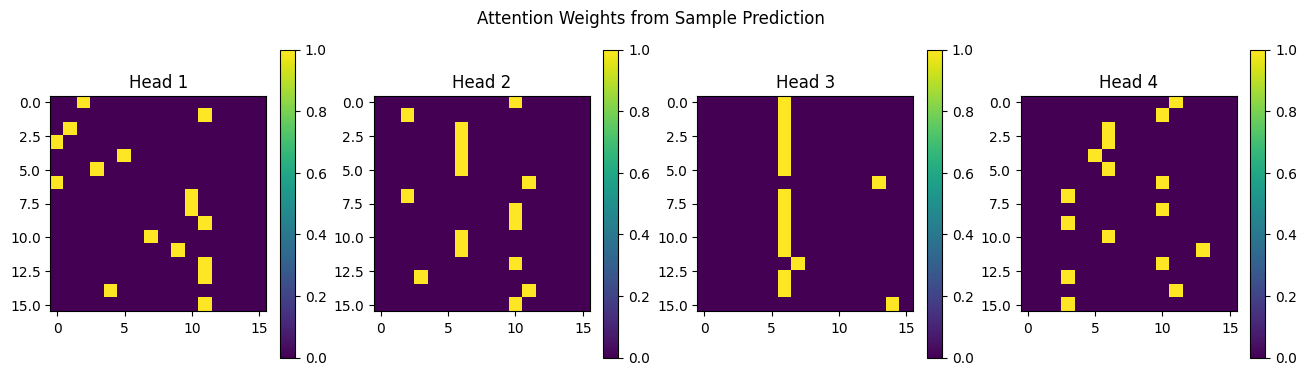

In [136]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np

# Check for available GPUs.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs found. Ensure tensorflow-macos and tensorflow-metal are installed for GPU acceleration on M2 Macs.")


# ---------------------------
# Gumbel Softmax Layer with Hard Sampling
# ---------------------------
class GumbelSoftmax(layers.Layer):
    def __init__(self, temperature=1.0, hard=False, **kwargs):
        super(GumbelSoftmax, self).__init__(**kwargs)
        self.temperature = temperature
        self.hard = hard

    def sample_gumbel(self, shape, eps=1e-20):
        U = tf.random.uniform(shape, minval=0, maxval=1)
        return -tf.math.log(-tf.math.log(U + eps) + eps)

    def call(self, logits):
        noise = self.sample_gumbel(tf.shape(logits))
        y = logits + noise
        y_soft = tf.nn.softmax(y / self.temperature, axis=-1)
        if self.hard:
            y_hard = tf.one_hot(tf.argmax(y_soft, axis=-1), depth=tf.shape(y_soft)[-1])
            # Use the straight-through estimator.
            y = tf.stop_gradient(y_hard - y_soft) + y_soft
            return y
        else:
            return y_soft


# ---------------------------
# Aggregation Layer
# ---------------------------
class AggregationLayer(layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Aggregation not implemented. Use 'mean' or 'max'.")


# ---------------------------
# Custom Multi-Head Attention with Gumbel Softmax
# ---------------------------
class CustomMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, attn_temperature=1.0, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.attn_temperature = attn_temperature
        self.attn_matrix = []  # List to store attention matrices.

    def build(self, input_shape):
        # Define weight matrices for Q, K, V.
        self.wq = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wq")
        self.wk = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wk")
        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # Reshape x to (batch_size, seq_len, num_heads, depth) then transpose.
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def reset_attention_matrix(self):
        """Clears the stored attention matrices."""
        self.attn_matrix = []

    def call(self, x):
        batch_size = tf.shape(x)[0]

        # Compute Q, K, V.
        q = tf.matmul(x, self.wq)  # (batch_size, seq_len, d_model)
        k = tf.matmul(x, self.wk)
        v = tf.matmul(x, self.wv)

        # Split into multiple heads.
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Compute scaled dot-product attention logits.
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len, seq_len)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Apply Gumbel Softmax (with hard sampling) instead of standard softmax.
        gumbel_layer = GumbelSoftmax(temperature=self.attn_temperature, hard=True)
        attention_weights = gumbel_layer(scaled_attention_logits)

        # Compute attention output.
        scaled_attention = tf.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, depth)

        # Concatenate heads.
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len, d_model)

        # Final linear layer.
        output = self.dense(concat_attention)

        # Use tf.py_function to convert attention_weights to a concrete (numpy-backed) tensor.
        # The lambda here receives a numpy array and returns it.
        np_attention = tf.py_function(func=lambda t: t, inp=[attention_weights], Tout=tf.float32)
        np_attention.set_shape(attention_weights.shape)
        self.attn_matrix.append(np_attention)
        
        return output, attention_weights


# ---------------------------
# Transformer Block
# ---------------------------
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, attn_temperature=1.0, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.mha = CustomMultiHeadAttention(d_model, num_heads, attn_temperature=attn_temperature)
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.outD = layers.Dense(16)
        self.outD2 = layers.Dense(16)

    def call(self, x):
        # Multi-head attention sub-layer.
        attn_output, _ = self.mha(x)
        out1 = self.outD(x + attn_output)
        # Feed-forward sub-layer.
        ffn_output = self.ffn(out1)
        out2 = out1 + ffn_output
        out2 = self.outD2(out2)
        return out2


# ---------------------------
# Model Definition
# ---------------------------
def build_custom_transformer_classifier(num_particles, feature_dim,
                                          d_model=16, d_ff=16, output_dim=16,
                                          num_heads=1, attn_temperature=0.5):
    """
    Builds a classifier model with:
      - A linear embedding layer.
      - A transformer encoder block using Gumbel Softmax in attention.
      - Aggregation over the sequence dimension using AggregationLayer.
      - A final dense output layer for 5 classes.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    # Linear embedding.
    x = layers.Dense(16, activation='relu')(inputs)

    # Apply a transformer block.
    transformer_block = TransformerBlock(16, 16, output_dim=8, num_heads=num_heads, attn_temperature=attn_temperature)
    x = transformer_block(x)
    
    # Custom aggregation (using "max" aggregation here).
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    # Final dense layers.
    x = layers.Dense(16, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    # Attach the transformer block to the model for later access.
    model.transformer_block = transformer_block
    return model


# ---------------------------
# Plotting Function for Attention Matrices
# ---------------------------
def plot_attention_matrices(attn_matrix, title="Attention Weights"):
    """
    Expects attn_matrix to be a list of concrete (numpy) tensors, where each element has shape:
      (batch_size, num_heads, seq_len, seq_len)
    This function plots the attention map for the first sample in the batch
    across all heads from the last recorded attention weights.
    """
    if not attn_matrix:
        print("No attention matrices to plot.")
        return

    # Evaluate the last stored attention matrix (if needed).
    weights = attn_matrix[-1]
    # If weights are still a tf.Tensor, convert to numpy.
    if hasattr(weights, "numpy"):
        weights = weights.numpy()
        
    # Check that we have a batch dimension.
    if weights.ndim != 4:
        print("Unexpected shape for attention weights:", weights.shape)
        return

    batch_size, num_heads, seq_len, _ = weights.shape
    fig, axes = plt.subplots(1, num_heads, figsize=(num_heads * 4, 4))
    if num_heads == 1:
        axes = [axes]
    for i in range(num_heads):
        ax = axes[i]
        im = ax.imshow(weights[0, i, :, :], cmap='viridis')
        ax.set_title(f'Head {i + 1}')
        fig.colorbar(im, ax=ax)
    plt.suptitle(title)
    plt.show()


# ---------------------------
# Training / Evaluation / Plotting Example
# ---------------------------
# For demonstration, we'll create dummy data.
num_particles = 16
feature_dim = 3  # (Make sure this matches your data)

# Dummy data.

# Build the model.
model = build_custom_transformer_classifier(num_particles, feature_dim,
                                            d_model=8, d_ff=8,
                                            output_dim=8, num_heads=4,
                                            attn_temperature=0.1)

# Attempt to load saved weights.
try:
    model.load_weights('model_gumbel_softmax16noLN.weights.h5')
    print("Weights loaded successfully.")
except ValueError as e:
    print("Error loading weights:", e)
    print("Skipping weight loading. Ensure the model architecture matches the saved weights if you intend to load them.")

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# (Optional) Train the model.
# model.fit(x_train, y_train, epochs=5, batch_size=16)

# Clear any stored attention matrices.
model.transformer_block.mha.reset_attention_matrix()

# Run a prediction to record attention weights.
sample_input = x_train[:5]  # Use a few samples.
predictions = model.predict(sample_input)

# Retrieve and plot the attention weights from the custom multi-head attention layer.
attn_matrix = model.transformer_block.mha.attn_matrix
plot_attention_matrices(attn_matrix, title="Attention Weights from Sample Prediction")


In [134]:
x_train[:5].shape

(5, 16, 3)